<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Небходимо построить модель с предельно большим значением *F1*-меры. И проверить *F1*-меру на тестовой выборке.

Дополнительно будем измерять *AUC-ROC*, сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Для начала импортируем необходимые для работы с данными библиотеки, модели и метрики.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler  
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve



Прочитаем файл с исходными данными и сохраним его как датасет data

In [3]:
data=pd.read_csv('Churn.csv')

Ознакомимся с данными, воспользовавшись функцией head()

In [4]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Изучим данные более внимательно, воспользовавшись функцией info()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Таким образом, мы видим, что типы данных соответствуют ожидаемым, в столбце Tenure имеются пропуски. Приведем названия столбцов в порядок 

In [6]:
for inx, name in enumerate(data.columns):
    data.rename(
        columns=
        {data.columns[inx]: 
         '_'.join(re.findall('[A-Z][^A-Z]*', 
                             data.columns[inx]))
         .lower()}, inplace=True)

Проверим полученный результат

In [7]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Заполним пропуски в столбце tenure, для этого посмотрим подробнее на распределение данного признака

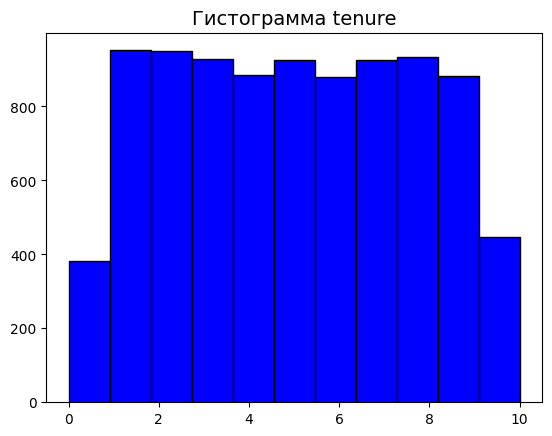

In [8]:
plt.hist(data['tenure'], color ='blue', edgecolor='black', linewidth=1, bins=11)
plt.title('Гистограмма tenure', fontsize=14)
plt.show()

In [9]:
data['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [10]:
data[['tenure', 'exited']].corr()

,tenure,exited
tenure,1.000000,-0.016761
exited,-0.016761,1.000000


Корреляция отсутствует, а метрики среднего одинаковые. Так как крайние значения не велики, используем медиану при заполнении пропусков.

In [11]:
data['tenure'].fillna(data['tenure'].median(), inplace=True)

Проверим полученный результат

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим, что пропуски в столбце tenure исчезли

Удалим лишние столбцы, которые не повлияют на обучение модели

In [13]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

Посмотрим на признаки более детально, воспользовавшись функцией describe()

In [14]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Посмотрим на распределение признаков на графиках

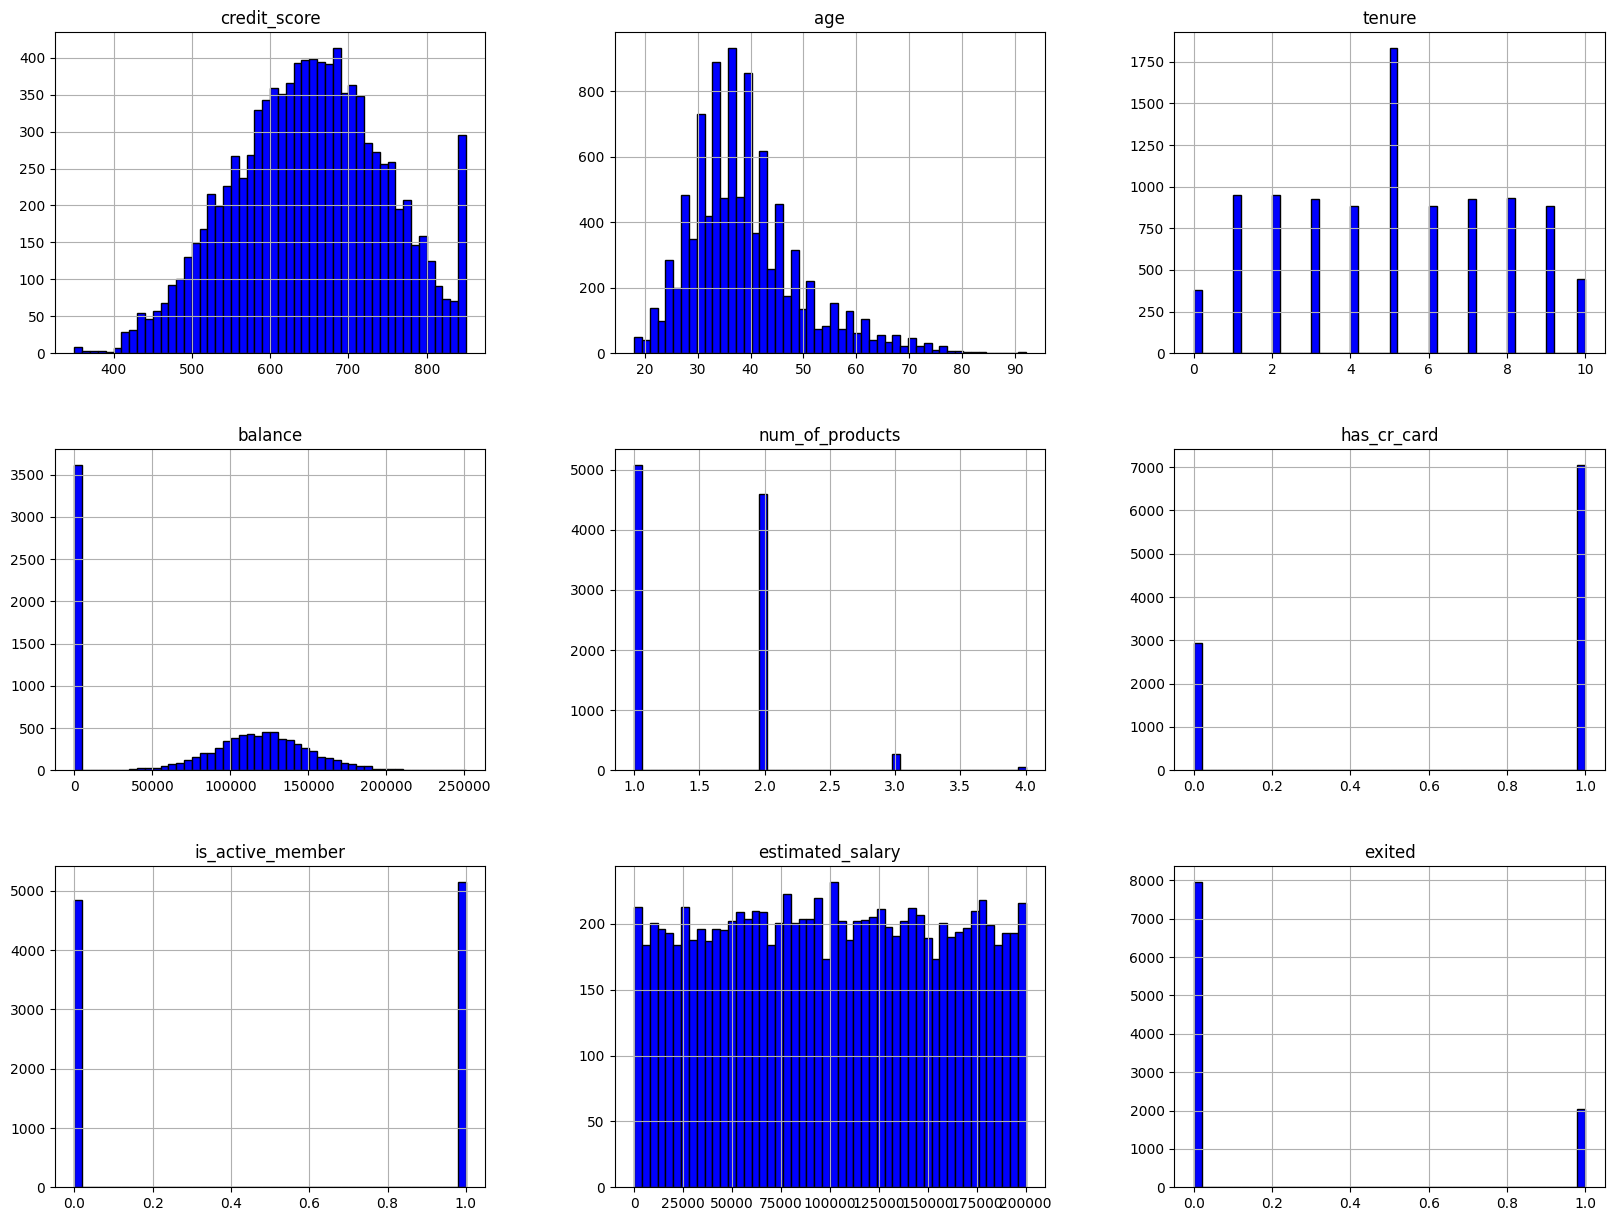

In [15]:
data.hist(bins=50, figsize=(20,15), color='blue', edgecolor='black', linewidth=1)
plt.show()

Таким образом мы можем наблюдать большой разброс значений, значит потребуется масштабирование признаков. разброс значений потребует Кроме того мы увидели выбросы: данные признака credit_score явно ограничены по правой стороне и имеется длинный уходящий влево хвост.
Данные признака balance могут быть ограничены по левой стороне, видим длинный хвост распределения влево и вправо. Признаки credit_score, age, tenure, balance стремятся к колоколообразному распределнию, а вот распределение значений признака estimated_salary вызывает вопросы.

## Исследование задачи

Исследуем баланс классов. Для начала посмотрим, как распределен целевой признак

In [16]:
data['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [17]:
part = data['exited'].value_counts()[1] / data['exited'].value_counts()[0]
print(f'Доля положительного целевого признака в выборке {part:.2%}')

Доля положительного целевого признака в выборке 25.58%


Наблюдаем крайне неравномерное распределение распределение целевого признака. Выборка содержит порядка 26% положительных значений.
Для ищбавления от дисбаланса можно воспользоваться методами увеличения или уменьшения выборки. 
Доля целевой положительной метки 25%. Для равного веса, необходимо вернуть 0.33 отрицательного класса целевого признака.

Разделим датасет на признаки и целевой признак, при этом преобразуем категориальные признаки в численные методом прямого кодирования

In [18]:
data_ohe = pd.get_dummies(data, columns = ['geography', 'gender'], drop_first=True)

In [19]:
features = data_ohe.drop('exited', axis=1)
features.shape

(10000, 11)

In [20]:
target = data_ohe['exited']
target.shape

(10000,)

Проверим получившийся результат

In [21]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Приведем численные признаки к одному масштабу с помощью StandardScaler()

In [22]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])

features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,-1.086246,-1.225848,-0.911583,1,1,0.021886,0,0,0
1,-0.440036,0.198164,-1.448581,0.117350,-0.911583,0,1,0.216534,0,1,0
2,-1.536794,0.293517,1.087768,1.333053,2.527057,1,0,0.240687,0,0,0
3,0.501521,0.007457,-1.448581,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,0.388871,-1.086246,0.785728,-0.911583,1,1,-0.365276,0,1,0


Разделим исходный набор данных на обучающую, валидационную и тестовую выборки с помощью функции train_test_split из библиотеки sklearn. Исходные данные разбиваем в соотношении 3:1:1, размер тестовой и валидационной выборок одинаков, следовательно, должно получиться соотношение 60%:20%:20%. Выведем размер полученных выборок с помощью shape.

In [23]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

print(features_train.shape) 
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


Обучим модели без учета дисбаланса классов. Рассмотрим три модели решающего дерева, случайного леса и логистической регрессии. Рассчитаем агрегирующую метку F1-score

In [44]:
model = DecisionTreeClassifier(random_state=6789) 
model.fit(features_train, target_train)
predicted_valid = model.predict (features_valid)
result = f1_score(target_valid, predicted_valid)
result

0.4969987995198079

Рассчитаем метрику roc_auc

In [45]:
prob_one_valid = model.predict_proba(features_valid)
roc_auc = roc_auc_score(target_valid,prob_one_valid[:,1])
roc_auc

0.6818680853380433

Построим таблицу ошибок

In [46]:
confusion_matrix(target_valid, predicted_valid)

array([[1374,  208],
       [ 211,  207]])

In [49]:
model = RandomForestClassifier(random_state=6789) 
model.fit(features_train, target_train)
predicted_valid = model.predict (features_valid)
result = f1_score(target_valid, predicted_valid)
result

0.5896296296296296

In [50]:
prob_one_valid = model.predict_proba(features_valid)
roc_auc = roc_auc_score(target_valid,prob_one_valid[:,1])
roc_auc

0.8358998360744985

In [51]:
confusion_matrix(target_valid, predicted_valid)

array([[1524,   58],
       [ 219,  199]])

In [52]:
model = LogisticRegression(random_state=6789, solver='liblinear') 
model.fit(features_train, target_train)
predicted_valid = model.predict (features_valid)
result = f1_score(target_valid, predicted_valid)
result

0.33108108108108103

In [53]:
prob_one_valid = model.predict_proba(features_valid)
roc_auc = roc_auc_score(target_valid,prob_one_valid[:,1])
roc_auc

0.7587497504824008

In [54]:
confusion_matrix(target_valid, predicted_valid)

array([[1506,   76],
       [ 320,   98]])

Таким образом, мы обучили три разные модели без учета дисбаланса. Наибольшее значение метрики F1-score и roc_auc_score было получено на модели случайного леса при гиперпараметрах.

## Борьба с дисбалансом

Чтобы сделать сделать объекты редкого класса не такими редкими в данных, воспользуемся способом уменьшения выборки. Для начала разделим обучающую выборку на отрицательные и положительные объекты

In [55]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]
print(features_zeros.shape)
print(target_zeros.shape)
print(features_ones.shape)
print(target_ones.shape)

(4804, 11)
(4804,)
(1196, 11)
(1196,)


Случайным образом отбрасываем часть отрицательных объектов

In [56]:
features_zeros_sample = features_zeros.sample(frac=0.75, random_state=6789)
target_zeros_sample = target_zeros.sample(frac=0.75, random_state=6789)
print(features_zeros_sample.shape)
print(target_zeros_sample.shape)

(3603, 11)
(3603,)


Объединим положительные и отрицательные признаки, а затем перемешаем их

In [57]:
features_balanced = pd.concat([features_zeros_sample]+[features_ones]*3)
features_balanced.shape

(7191, 11)

In [58]:
target_balanced = pd.concat([target_zeros_sample]+[target_ones]*3)
target_balanced.shape

(7191,)

In [59]:
features_balanced, target_balanced = shuffle(features_balanced, target_balanced, random_state = 6789)

Изучим модель случайного леса с числом деревьев от 10 до 50 и значениями гиперпаметра max_depth от 1 до 10

In [60]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=6789, n_estimators=est, max_depth=depth) 
        model.fit(features_balanced, target_balanced)
        predicted_valid = model.predict (features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
        
print(f"F1-score наилучшей модели на валидационной выборке при n_estimators={best_est} и max_depth={best_depth}: {best_result}")

F1-score наилучшей модели на валидационной выборке при n_estimators=30 и max_depth=8: 0.6268343815513627


Здесь получили необходимое увеличение значения f1-score. Посмотрим, как это сработает на других моделях с разными гиперпараметрами

In [61]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=6789, max_depth=depth) 
    model.fit(features_balanced, target_balanced)
    predicted_valid = model.predict (features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print(f"F1-score наилучшей модели на валидационной выборке при max_depth={best_depth}: {best_result}")

F1-score наилучшей модели на валидационной выборке при max_depth=4: 0.5655042412818096


In [62]:
best_model = None
best_result = 0
best_samples = 0
for samples in range(1, 11):
    model = DecisionTreeClassifier(random_state=6789, min_samples_leaf=samples) 
    model.fit(features_balanced, target_balanced)
    predicted_valid = model.predict (features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_samples = samples
        
print(f"F1-score наилучшей модели на валидационной выборке при min_samples_leaf={best_samples}: {best_result}")

F1-score наилучшей модели на валидационной выборке при min_samples_leaf=7: 0.5084388185654009


In [65]:
best_model = None
best_result = 0
best_criterion = None
list_crit=['gini', 'entropy']
for n in list_crit:
    model = DecisionTreeClassifier(random_state=6789, criterion=n) 
    model.fit(features_balanced, target_balanced)
    predicted_valid = model.predict (features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_criterion = n
print(f"F1-score наилучшей модели на валидационной выборке при criterion='{best_criterion}':{best_result}")

F1-score наилучшей модели на валидационной выборке при criterion='gini':0.49601820250284406


Исследуем обучающую и валидационную выборки с помощью модели логистической регрессии, меняя гиперпараметр class_weight

In [66]:
best_model = None
best_result = 0
best_class_weight = None 
class_weight_list = [None, 'balanced']
for c in class_weight_list:
    model = LogisticRegression(random_state=6789, solver='liblinear', class_weight=c) 
    model.fit(features_balanced, target_balanced)
    predicted_valid = model.predict (features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
            best_model = model
            best_result = result
            best_class_weight = c
            
            
print(f"F1-score наилучшей модели на валидационной выборке при class_weight={best_class_weight}:{best_result}")

F1-score наилучшей модели на валидационной выборке при class_weight=balanced:0.4855687606112054


Лучший результат показала модель случайного леса. Найдем лучшее значение порога для модели случайного леса.

In [67]:
model = RandomForestClassifier(random_state=6789, n_estimators=50, max_depth=9) 
model.fit(features_balanced, target_balanced)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
best_score = 0
best_threshold = 0

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    result = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid)


    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}, auc_roc = {:3f}".format(
        threshold, precision, recall, result, auc_roc))
    if best_score < result:
        best_score = result
        best_threshold = threshold
print(f"Лучшее значение порога: {best_threshold}, f1-score={best_score}")

Порог = 0.00 | Точность = 0.209, Полнота = 1.000 | F1-мера = 0.346, auc_roc = 0.500000
Порог = 0.05 | Точность = 0.211, Полнота = 1.000 | F1-мера = 0.348, auc_roc = 0.504741
Порог = 0.10 | Точность = 0.228, Полнота = 0.993 | F1-мера = 0.370, auc_roc = 0.551405
Порог = 0.15 | Точность = 0.254, Полнота = 0.969 | F1-мера = 0.402, auc_roc = 0.608344
Порог = 0.20 | Точность = 0.279, Полнота = 0.947 | F1-мера = 0.431, auc_roc = 0.650675
Порог = 0.25 | Точность = 0.315, Полнота = 0.923 | F1-мера = 0.470, auc_roc = 0.696552
Порог = 0.30 | Точность = 0.352, Полнота = 0.885 | F1-мера = 0.504, auc_roc = 0.727666
Порог = 0.35 | Точность = 0.397, Полнота = 0.830 | F1-мера = 0.538, auc_roc = 0.748827
Порог = 0.40 | Точность = 0.452, Полнота = 0.792 | F1-мера = 0.576, auc_roc = 0.769195
Порог = 0.45 | Точность = 0.507, Полнота = 0.744 | F1-мера = 0.603, auc_roc = 0.776245
Порог = 0.50 | Точность = 0.563, Полнота = 0.691 | F1-мера = 0.621, auc_roc = 0.774897
Порог = 0.55 | Точность = 0.602, Полнота = 

 Визуализируем полученный результат, построив PR- и ROC-кривые

Text(0.5, 1.0, 'PR-кривая')

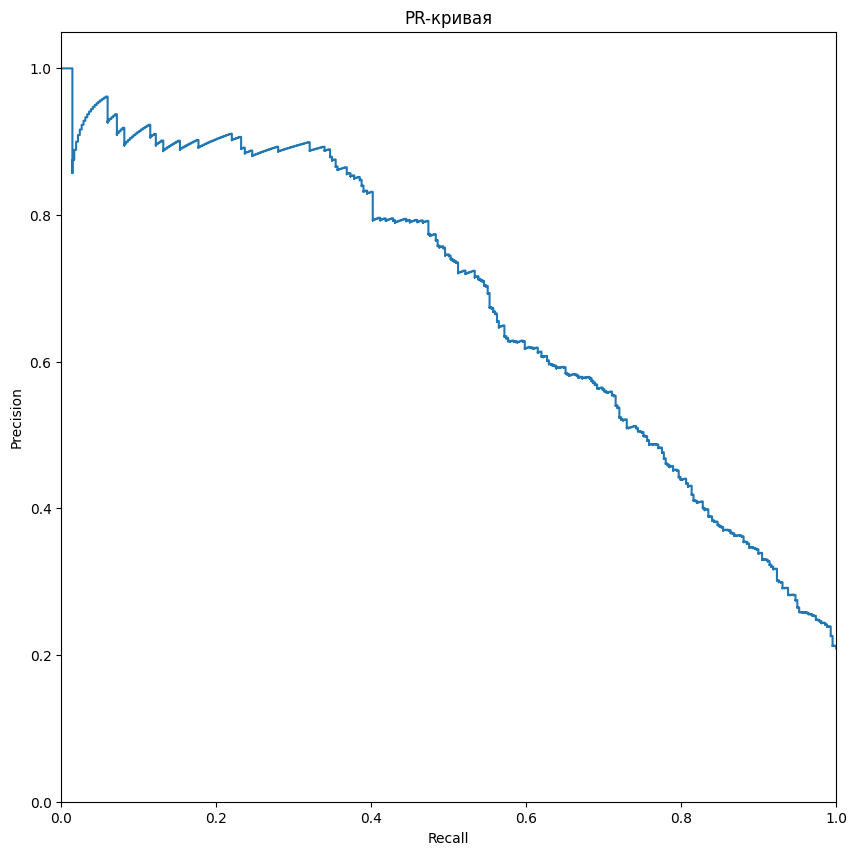

In [68]:
precision, recall, thresholds = precision_recall_curve(
        target_valid, probabilities_valid[:, 1]
    )    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR-кривая')

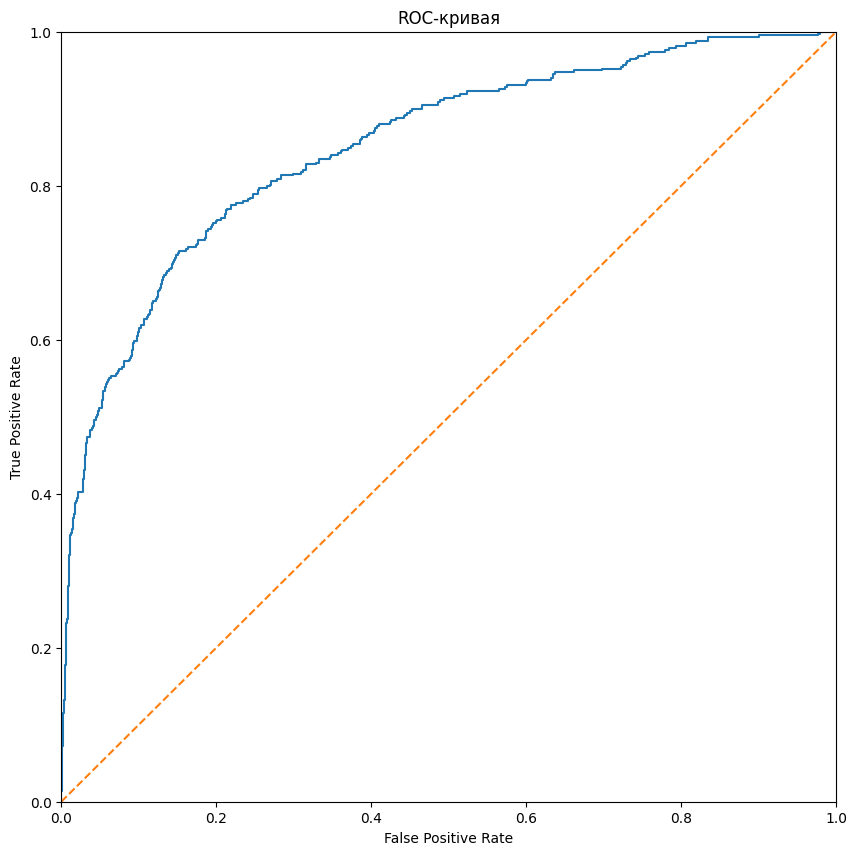

In [69]:
 fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
   
plt.show()

Лучший результат показала модель RandomForestClassifier с измененным порогом при n_estimators=40, max_depth=9. Лучшее значение метрики f1-score было получено при пороге = 0.55. 

## Тестирование модели

Проведем финальное тестирование на данных из тестовой выборки

In [71]:
model_final = RandomForestClassifier (random_state=6789, n_estimators = 40, max_depth=9)
model_final.fit(features_balanced, target_balanced)
predicted_final = model_final.predict(features_test)
f1_final = f1_score(target_test, predicted_final)
f1_final

0.6042105263157895

Мы провели финальное тестирование, исследовали три различные модели решающее дерево, случайный лес и логистическую регрессию, оценили, при каком значении порога для каждой из данных моделей достигаются наилучшие метрики f1_score и auc_roc. По результатам всех проверок наилучший результат показала модель RandomForestClassifier. Целевая метрика для нее на тестовой выборке составила 0.60

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*